Predicting House Prices with Economic Indicators

Domain: Real Estate / Finance

Business Problem:
“Can macroeconomic indicators be used to accurately predict median house prices in the United States?”

Housing is a critical part of any nation's economy, and understanding the factors that influence home prices can provide valuable insights to investors, policymakers, and consumers. Economic signals such as inflation, interest rates, and unemployment are widely believed to affect housing markets, but the relationship is complex.

Context:
In a constantly fluctuating economy, stakeholders in the housing market—such as real estate firms, banks, and policy makers—need tools that can anticipate future trends. Predicting house prices based on economic indicators enables:

-Real estate firms to make informed investment decisions
-Banks to evaluate mortgage risk more accurately
-Policymakers to adjust fiscal strategies based on expected housing trends

This project aims to develop a predictive model that uses various economic indicators to forecast median house prices across the U.S., providing data-driven insights and visual dashboards to assist decision-making.

Objectives:
-Analyze trends in economic indicators (like inflation, unemployment, and mortgage rates) and their historical impact on house prices.

-Identify the most influential factors affecting house price movement.

-Develop a machine learning model to predict future house prices based on current and historical macroeconomic data.

-Explain model behavior using SHAP to ensure transparency in predictions.

-Evaluate the model’s fairness by analyzing potential biases (e.g., over/underestimation during economic booms or recessions).

-Visualize all key insights through an interactive QlikView dashboard for non-technical stakeholders.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chimavogu/us-economy-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/us-economy-dataset


In [ ]:
import pandas as pd

# Load the Excel files
income_df = pd.read_excel('/Average Individual Income By Year 1962-2021.xlsx')
sales_jan_df = pd.read_excel('/Average sales of Houses in Jan.xlsx')
sales_us_df = pd.read_excel('/Average sales of Houses in the US.xlsx')
inflation_df = pd.read_excel('/US Historical Inflation Rates 1914-2022.xlsx')

# Display the first few rows of each DataFrame to confirm
print("Average Individual Income By Year 1962-2021:")
print(income_df.head())

print("\nAverage sales of Houses in Jan:")
print(sales_jan_df.head())

print("\nAverage sales of Houses in the US:")
print(sales_us_df.head())

print("\nUS Historical Inflation Rates 1914-2022:")
print(inflation_df.head())


Average Individual Income By Year 1962-2021:
   Year  AverageIndividualIncome  InflationAdjusted2021  PercentChange
0  1962                  3712.21               32207.05            NaN
1  1963                  3710.28               31834.61          -1.16
2  1964                  3947.73               33319.70           4.67
3  1965                  4122.17               34417.90           3.30
4  1966                  4273.35               35113.82           2.02

Average sales of Houses in Jan:
  FirstQuarterYearly  AverageSalesPricesOfHousesInTheUS  PercentChange
0         1963-01-01                              19300            NaN
1         1964-01-01                              19600           0.00
2         1965-01-01                              21500           2.87
3         1966-01-01                              22700           4.61
4         1967-01-01                              24000           5.26

Average sales of Houses in the US:
  PerQuarterFrom1963to2021  Averag

#### 1. Preprocessing and Data Cleaning

In [ ]:
import pandas as pd

# --- Load Excel files ---
income_df = pd.read_excel('/Average Individual Income By Year 1962-2021.xlsx')
sales_jan_df = pd.read_excel('/Average sales of Houses in Jan.xlsx')
sales_us_df = pd.read_excel('/Average sales of Houses in the US.xlsx')
inflation_df = pd.read_excel('/US Historical Inflation Rates 1914-2022.xlsx')

# --- Clean Income Data ---
income_df.rename(columns={
    'Year': 'Year',
    'AverageIndividualIncome': 'Income',
    'InflationAdjusted2021': 'Income_Adj_2021',
    'PercentChange': 'Income_Change'
}, inplace=True)

# --- Clean Sales Jan Data ---
sales_jan_df.rename(columns={
    'FirstQuarterYearly': 'Date',
    'AverageSalesPricesOfHousesInTheUS': 'HousePrice_Jan',
    'PercentChange': 'HousePrice_Change'
}, inplace=True)

sales_jan_df['Date'] = pd.to_datetime(sales_jan_df['Date'])
sales_jan_df['Year'] = sales_jan_df['Date'].dt.year
sales_jan_df.drop('Date', axis=1, inplace=True)

# --- Clean Quarterly House Prices ---
sales_us_df.rename(columns={
    'PerQuarterFrom1963to2021': 'Date',
    'AverageSalesPricesOfHousesInTheUS': 'HousePrice_Quarter',
    'PercentChangeEveryQuarter': 'Quarterly_Change'
}, inplace=True)

sales_us_df['Date'] = pd.to_datetime(sales_us_df['Date'])
sales_us_df['Year'] = sales_us_df['Date'].dt.year

# Average house price per year
avg_quarterly_df = sales_us_df.groupby('Year').agg({'HousePrice_Quarter': 'mean'}).reset_index()

# --- Clean Inflation Data ---
inflation_df.rename(columns={'YEAR': 'Year', 'AVE': 'InflationRate'}, inplace=True)
inflation_df = inflation_df[['Year', 'InflationRate']]
inflation_df['InflationRate'] = pd.to_numeric(inflation_df['InflationRate'], errors='coerce')

# --- Merge All Datasets ---
merged_df = income_df.merge(sales_jan_df, on='Year', how='inner')
merged_df = merged_df.merge(avg_quarterly_df, on='Year', how='inner')
merged_df = merged_df.merge(inflation_df, on='Year', how='left')

# --- Final Cleanup ---
merged_df.sort_values('Year', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# --- Preview Final Merged Data ---
print("\nFinal Merged Dataset:")
print(merged_df.head())



Final Merged Dataset:
   Year   Income  Income_Adj_2021  Income_Change  HousePrice_Jan  \
0  1963  3710.28         31834.61          -1.16           19300   
1  1964  3947.73         33319.70           4.67           19600   
2  1965  4122.17         34417.90           3.30           21500   
3  1966  4273.35         35113.82           2.02           22700   
4  1967  4527.12         36240.30           3.21           24000   

   HousePrice_Change  HousePrice_Quarter  InflationRate  
0                NaN             19375.0            1.3  
1               0.00             20300.0            1.3  
2               2.87             21450.0            1.6  
3               4.61             22925.0            2.9  
4               5.26             24125.0            3.1  


#### 2. EDA

In [ ]:
# Summary statistics
print("Summary Statistics:")
print(merged_df.describe())

# Missing value check
print("\nMissing Values:")
print(merged_df.isnull().sum())


Summary Statistics:
              Year        Income  Income_Adj_2021  Income_Change  \
count    59.000000     59.000000        59.000000      59.000000   
mean   1992.000000  26045.451525     46307.119322       1.195085   
std      17.175564  17743.914150      7803.361720       2.411691   
min    1963.000000   3710.280000     31834.610000      -5.310000   
25%    1977.500000   9241.525000     40138.980000      -0.160000   
50%    1992.000000  22707.290000     43808.950000       1.120000   
75%    2006.500000  41607.550000     53175.615000       2.885000   
max    2021.000000  63214.030000     63533.860000       7.770000   

       HousePrice_Jan  HousePrice_Change  HousePrice_Quarter  InflationRate  
count       59.000000          58.000000           59.000000      59.000000  
mean    167745.762712           1.353448       170952.542373       3.822034  
std     120662.870788           3.189865       123051.967198       2.757689  
min      19300.000000          -7.090000        19375.0

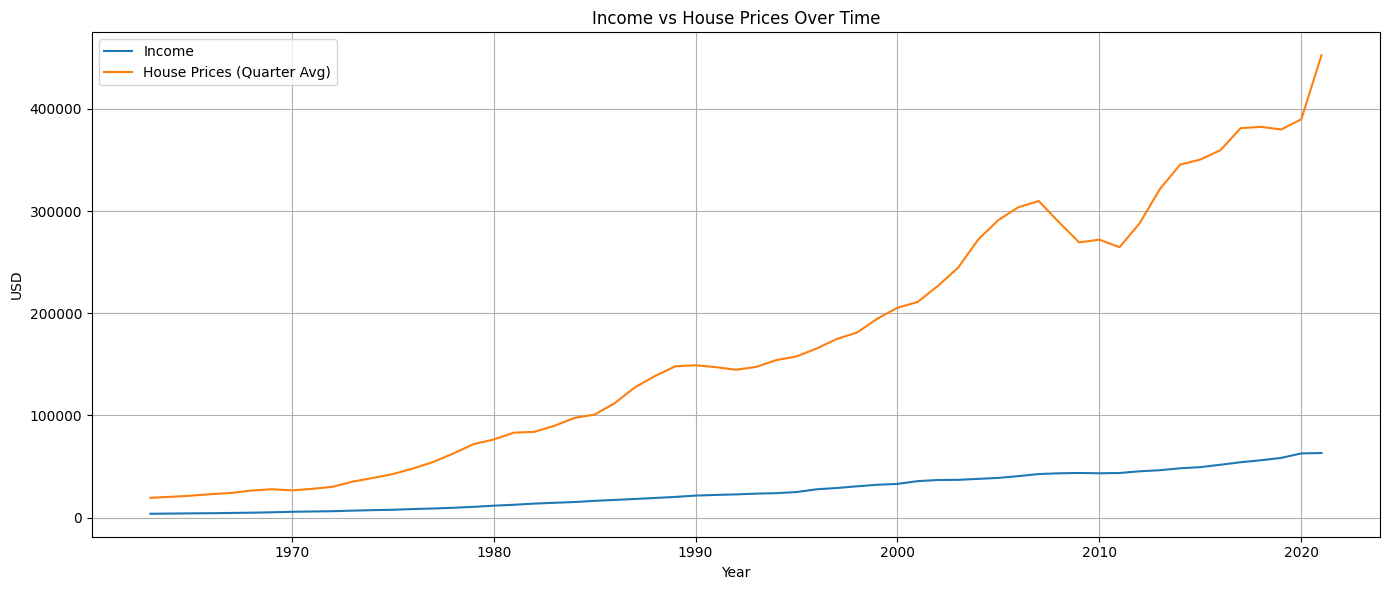

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=merged_df, x='Year', y='Income', label='Income')
sns.lineplot(data=merged_df, x='Year', y='HousePrice_Quarter', label='House Prices (Quarter Avg)')
plt.title("Income vs House Prices Over Time")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


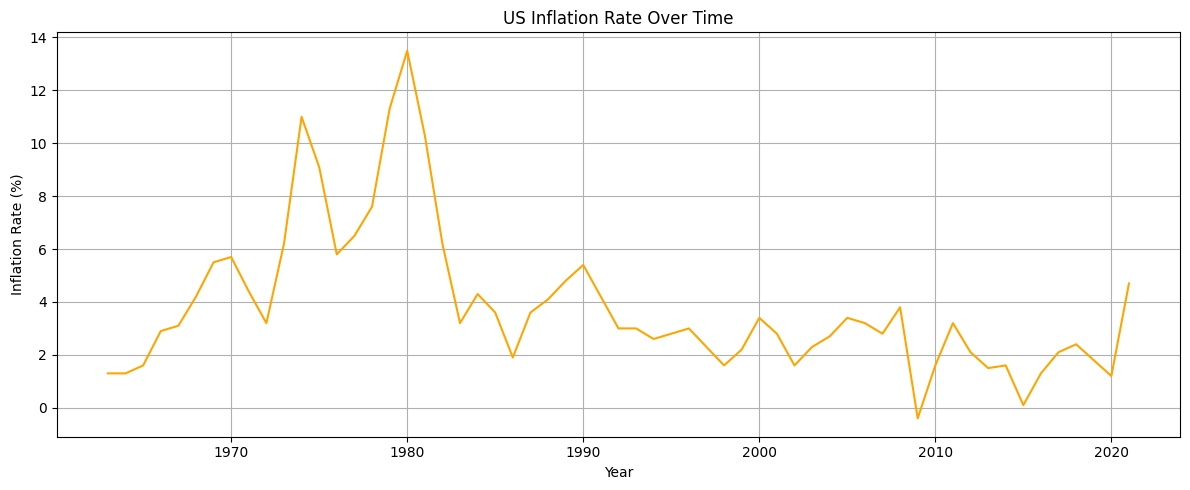

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged_df, x='Year', y='InflationRate', color='orange')
plt.title("US Inflation Rate Over Time")
plt.ylabel("Inflation Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


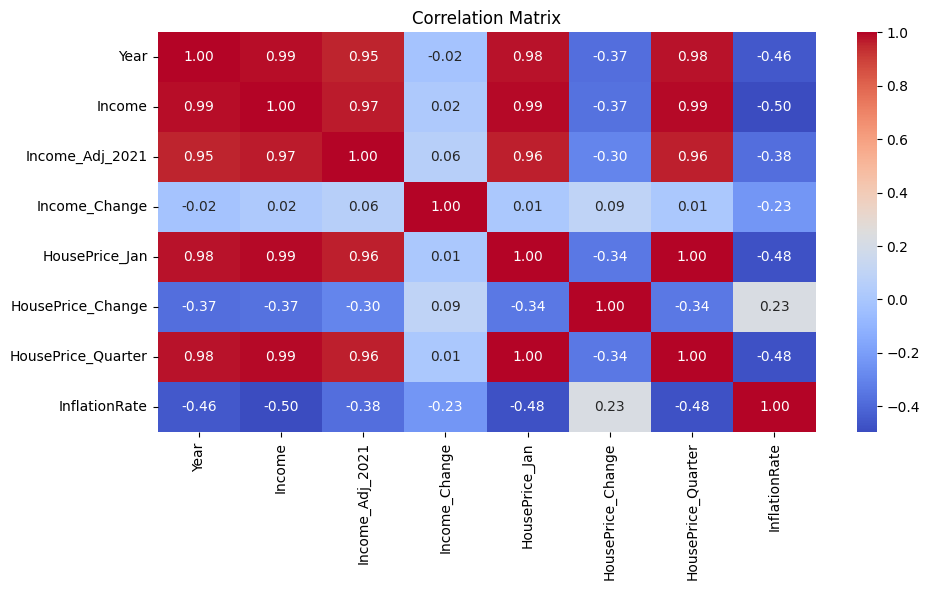

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


#### 3. Feature Selection and Engineering

In [ ]:
# 1. Income to Price Ratio
merged_df['Income_to_Price_Ratio'] = merged_df['Income'] / merged_df['HousePrice_Quarter']

# 2. Inflation-adjusted House Price (roughly approximated)
merged_df['Inflation_Adjusted_Price'] = merged_df['HousePrice_Quarter'] / (1 + merged_df['InflationRate'] / 100)

# 3. Lagged House Price
merged_df['Lagged_HousePrice'] = merged_df['HousePrice_Quarter'].shift(1)

# 4. Income Growth Rate (%)
merged_df['Income_Growth_Rate'] = merged_df['Income'].pct_change() * 100

# 5. House Price Growth Rate (%)
merged_df['Price_Growth_Rate'] = merged_df['HousePrice_Quarter'].pct_change() * 100

# Handle new NaNs after shifting/pct_change
merged_df.dropna(inplace=True)

# Display updated dataframe
merged_df.head()


,Year,Income,Income_Adj_2021,Income_Change,HousePrice_Jan,HousePrice_Change,HousePrice_Quarter,InflationRate,Income_to_Price_Ratio,Inflation_Adjusted_Price,Lagged_HousePrice,Income_Growth_Rate,Price_Growth_Rate
1,1964,3947.73,33319.70,4.67,19600,0.00,20300.0,1.3,0.194469,20039.486673,19375.0,6.399787,4.774194
2,1965,4122.17,34417.90,3.30,21500,2.87,21450.0,1.6,0.192176,21112.204724,20300.0,4.418742,5.665025
3,1966,4273.35,35113.82,2.02,22700,4.61,22925.0,2.9,0.186406,22278.911565,21450.0,3.667486,6.876457
4,1967,4527.12,36240.30,3.21,24000,5.26,24125.0,3.1,0.187653,23399.612027,22925.0,5.938432,5.234460
5,1968,4786.80,37169.50,2.56,25400,4.10,26425.0,4.2,0.181147,25359.884837,24125.0,5.736097,9.533679


#### 4. Predictive Modelling

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
features = [
    'Income', 'Income_Adj_2021', 'Income_Change',
    'InflationRate', 'Income_to_Price_Ratio',
    'Inflation_Adjusted_Price', 'Lagged_HousePrice',
    'Income_Growth_Rate', 'Price_Growth_Rate'
]
target = 'HousePrice_Quarter'

X = merged_df[features]
y = merged_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")


# Evaluate all models
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



Random Forest Performance:
R² Score: 0.9968
RMSE: 6729.67

Linear Regression Performance:
R² Score: 0.9997
RMSE: 1986.89

XGBoost Performance:
R² Score: 0.9944
RMSE: 8822.82


##### Ensemble Model

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define base learners
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('lr', LinearRegression())
]

# Define meta-learner
meta_learner = LinearRegression()

# Create stacking model
stack_model = StackingRegressor(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Train on training set
stack_model.fit(X_train, y_train)

# Evaluate performance
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

y_pred_stack = stack_model.predict(X_test)

r2_stack = r2_score(y_test, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Ensemble Stacking Performance:\nR² Score: {r2_stack:.4f}\nRMSE: {rmse_stack:.2f}")


Ensemble Stacking Performance:
R² Score: 0.9996
RMSE: 2321.30


#### 5. SHAP

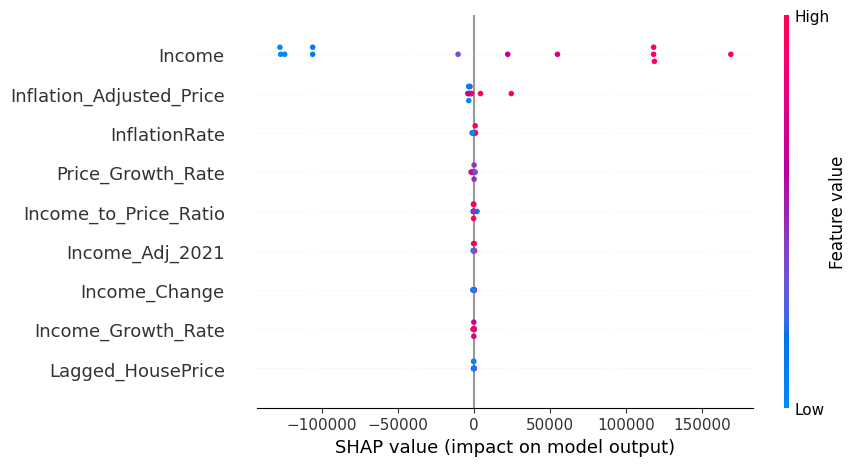

In [ ]:
import shap

# Let's use the XGBoost model from your stack
xgb_model = base_learners[1][1]  # this is the XGBRegressor
xgb_model.fit(X_train, y_train)  # re-train it standalone

# SHAP explainer
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)

# Plot
shap.plots.beeswarm(shap_values)


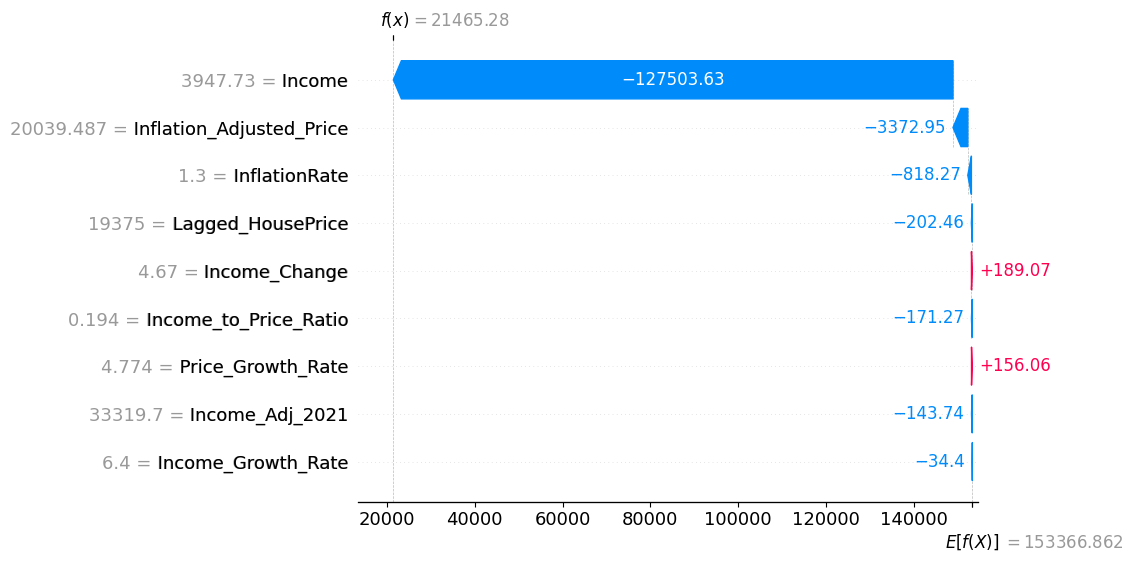

In [ ]:
shap.plots.waterfall(shap_values[0])  # for a specific row


The SHAP analysis explains how each feature affects the model’s predictions:

Income has the strongest negative impact, significantly lowering predicted house prices.

Inflation_Adjusted_Price and InflationRate also reduce the prediction.

Income_Change and Price_Growth_Rate have small positive effects, slightly increasing the predicted value.

This helps us understand which features drive predictions up or down, improving transparency and model explainability.

In [ ]:
import pickle

# Save the model
with open("stacking_model.pkl", "wb") as f:
    pickle.dump(stack_model, f)


In [ ]:
import pandas as pd
import pickle

# Define feature columns
features = [
    'Income', 'Income_Adj_2021', 'Income_Change',
    'InflationRate', 'Income_to_Price_Ratio',
    'Inflation_Adjusted_Price', 'Lagged_HousePrice',
    'Income_Growth_Rate', 'Price_Growth_Rate'
]

# Load model
with open("stacking_model.pkl", "rb") as f:
    model = pickle.load(f)

new_data = merged_df

# Ensure only the required features are used
X_new = new_data[features]

# Predict
predictions = model.predict(X_new)

# Output predictions
print("Predictions:")
print(predictions)


Predictions:
[ 18122.1053638   20352.49734782  23163.21814426  23990.36269813
  26769.94786893  28987.61834029  27778.12325102  26963.68481059
  28575.01083913  34514.8440989   42728.87861164  44200.20209968
  46639.7905907   54068.49568719  63063.87754873  73514.39933571
  78143.8377595   82162.886539    82162.50545966  88611.93579163
  97934.86447319  99898.80151284 111994.10414843 128009.31344762
 138541.01790636 147489.81322342 147648.65935783 146341.82694464
 144406.26561779 147454.00190374 154795.42638825 157724.44639218
 163858.37845684 174913.17257939 180949.41716256 195004.70027918
 204887.44561154 207652.09282657 227464.59451681 245896.49152433
 272792.25422624 289904.55303051 301307.2613419  307452.11049668
 283131.38280051 271552.33606459 274350.40835431 261700.26114691
 288381.93675571 325174.9268802  347665.89463658 355637.58260224
 361518.06006522 381704.1650582  380088.88115897 378829.52764607
 391244.26483924 448324.91240343]


In [ ]:
merged_df.to_excel("merged_df.xlsx", index=False)
import os
print(os.getcwd())  # shows the current directory



/content


In [ ]:
import pandas as pd

# Add predictions to your DataFrame
merged_df['Predicted_HousePrice'] = predictions

# Save to Excel file
merged_df.to_excel("house_prices_with_predictions.xlsx", index=False)


In [ ]:
import shap
import pandas as pd
import pickle

# Load the trained model
with open("stacking_model.pkl", "rb") as f:
    model = pickle.load(f)

# Load your input data
features = [
    'Income', 'Income_Adj_2021', 'Income_Change',
    'InflationRate', 'Income_to_Price_Ratio',
    'Inflation_Adjusted_Price', 'Lagged_HousePrice',
    'Income_Growth_Rate', 'Price_Growth_Rate'
]
X = merged_df[features]

# Create a SHAP explainer (assuming it's a tree-based model like RandomForest)
explainer = shap.Explainer(model.named_estimators_['rf'], X)  # Replace 'rf' with your actual base model if needed
shap_values = explainer(X)

# Get mean absolute SHAP values for feature importance
shap_df = pd.DataFrame({
    "Feature": features,
    "SHAP_Importance": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="SHAP_Importance", ascending=False)


In [ ]:
shap_df.to_excel("shap_feature_importance.xlsx", index=False)
